In [13]:
# from google.colab import files
# uploaded = files.upload()  # For dataset upload

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
 # Use your actual file path
df = pd.read_csv("heart_disease_uci.csv")

# Handling Missing Values
df['trestbps'].fillna(df['trestbps'].median(), inplace=True)
df['chol'].fillna(df['chol'].median(), inplace=True)
df['thalch'].fillna(df['thalch'].median(), inplace=True)
df['oldpeak'].fillna(df['oldpeak'].median(), inplace=True)
df['slope'].fillna(df['slope'].mode()[0], inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)

# Dropping 'ca' due to excessive missing values
df.drop(columns=['ca'], inplace=True)

# Encoding Binary Categorical Features
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['fbs'] = df['fbs'].map({True: 1, False: 0})
df['exang'] = df['exang'].map({True: 1, False: 0})

# One-Hot Encoding for Multi-Class Categorical Features
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

# Feature Scaling (Standardization)
scaler = StandardScaler()
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Converting 'num' to Binary Classification (Heart Disease: 1, No Disease: 0)
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Save the preprocessed dataset
df.to_csv("heart_disease_uci_processed.csv", index=False)

print("Preprocessing Complete! Processed dataset saved as 'heart_disease_uci_processed.csv'.")


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.experimental import enable_iterative_imputer  # Just enabling it
from sklearn.impute import IterativeImputer  # Import the actual imputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

imputer = IterativeImputer(max_iter=10, random_state=42)
df[['trestbps', 'chol', 'oldpeak', 'thalch']] = imputer.fit_transform(df[['trestbps', 'chol', 'oldpeak', 'thalch']])

# Identifying Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)

# Encoding Categorical Variables
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])  # Convert categories to numbers

# Splitting Data
X = df.drop('num', axis=1)
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Ensure all features are numeric before training
print(X_train.dtypes)

In [16]:


# Handling Missing Values with Imputation
imputer = SimpleImputer(strategy="most_frequent")  # You can change strategy to "mean" or "median" for numerical data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Verify that there are no missing values left
print(X_train.isnull().sum().sum())  # Should print 0


0


In [17]:

# Check available columns
print("Available columns:", df.columns)

# Define numeric columns, ensuring they exist
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Keep only existing numeric columns
numeric_cols = [col for col in numeric_cols if col in df.columns]

# Plot histograms for several numeric variables
plt.figure(figsize=(16, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplot for outlier detection
plt.figure(figsize=(16, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# Countplot for categorical features
plt.figure(figsize=(14, 5))

if 'sex' in df.columns:
    plt.subplot(1, 2, 1)
    sns.countplot(x='sex', data=df, palette='pastel')
    plt.title('Count Plot of Sex')

if 'cp' in df.columns:
    plt.subplot(1, 2, 2)
    sns.countplot(x='cp', data=df, palette='muted')
    plt.title('Count Plot of Chest Pain Type (cp)')

plt.tight_layout()
plt.show()

# Correlation heatmap
numeric_df = df[numeric_cols]
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(8, 6))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap for Numeric Features')
    plt.tight_layout()
    plt.show()

# Pair plot to inspect relationships among numeric features
if 'num' in df.columns:
    sns.pairplot(df[numeric_cols + ['num']], hue='num', palette='Set2')
    plt.show()
else:
    print("Skipping pair plot: 'target' column not found.")


Model: Decision Tree Classifier
Test Accuracy: 0.7935

Precision: 0.8519

Recall: 0.8070

F1-Score: 0.8288



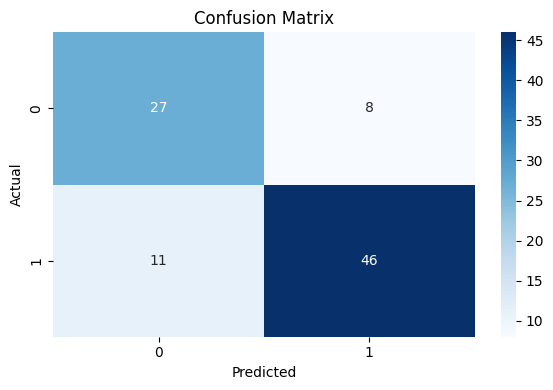

Model: Naïve Bayes Classifier
Test Accuracy: 0.7935

Precision: 0.8393

Recall: 0.8246

F1-Score: 0.8319



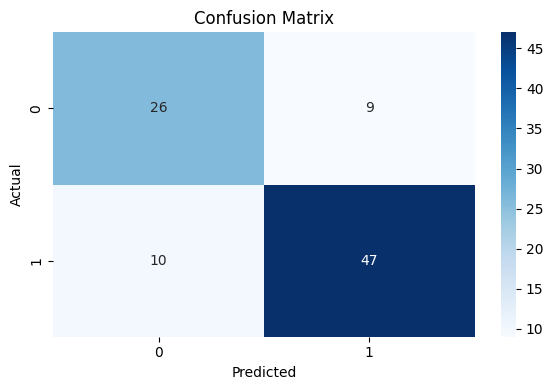

Model: Random Forest Classifier
Test Accuracy: 0.8478

Precision: 0.8644

Recall: 0.8947

F1-Score: 0.8793



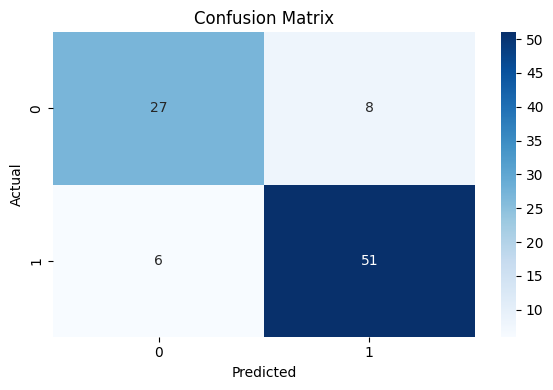

In [18]:

# Define models
models = [
    ('Decision Tree Classifier', DecisionTreeClassifier(random_state=42)),
    ('Naïve Bayes Classifier', GaussianNB()),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42))
]

best_model = None
best_accuracy = 0.0
accuracies=[]
precisions=[]
Recalls=[]
F1_scores=[]

# Iterate over models
for name, model in models:
    pipeline = Pipeline([('model', model)])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Test Accuracy: {accuracy:.4f}\n")
    print(f"Precision: {precision:.4f}\n")
    print(f"Recall: {recall:.4f}\n")
    print(f"F1-Score: {f1:.4f}\n")
    # Confusion Matrix visualization
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    accuracies.append(accuracy)
    precisions.append(precision)
    Recalls.append(recall)
    F1_scores.append(f1)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Visualization of Model Accuracy

model_names = ['Decision Tree', 'Naïve Bayes', 'Random forest']

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette='viridis')

plt.xlabel("Machine Learning Models")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Visualization of Model Precision

model_names = ['Decision Tree', 'Naïve Bayes', 'Random Forest']

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=precisions, palette='viridis')

plt.xlabel("Machine Learning Models")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.title("Model Precision Comparison")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Visualization of Model Recall accuracy

model_names = ['Decision Tree', 'Naïve Bayes', 'Random Forest']

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=Recalls, palette='viridis')

plt.xlabel("Machine Learning Models")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.title("Model Recall Comparison")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Visualization of Model F1-score

model_names = ['Decision Tree', 'Naïve Bayes', 'Random Forest']

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=F1_scores, palette='viridis')

plt.xlabel("Machine Learning Models")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.title("Model F1-score3 Comparison")
plt.show()

In [23]:
print(f"Best Model: {best_model} Accuracy: {best_accuracy}")

Best Model: Pipeline(steps=[('model', RandomForestClassifier(random_state=42))]) Accuracy: 0.8478260869565217
